In [1]:
import tensorflow as tf 
import matplotlib.pyplot as plt
import splitfolders
import pathlib

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
data_path = pathlib.Path('data')
splitfolders.ratio(data_path, output='output', seed=1337, ratio=(.8, .1, .1), group_prefix=None)
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_ds = data_gen.flow_from_directory('output/train', target_size=(64, 64), batch_size=32, class_mode='sparse', shuffle=True,subset='training')
val_ds = data_gen.flow_from_directory('output/val', target_size=(64, 64), batch_size=32, class_mode='sparse', shuffle=True,subset='validation')


Copying files: 1723 files [00:03, 450.88 files/s]


Found 1377 images belonging to 6 classes.
Found 0 images belonging to 6 classes.


In [4]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory='data', labels='inferred', label_mode='int', class_names=None, color_mode='rgb', batch_size=16, shuffle=True, seed=123, validation_split=.2,subset='training', interpolation='bilinear', follow_links=False)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory='data', labels='inferred', label_mode='int', class_names=None, color_mode='rgb', batch_size=16, shuffle=True, seed=123, validation_split=.2,subset='validation', interpolation='bilinear', follow_links=False)

Found 1723 files belonging to 6 classes.
Using 1379 files for training.
Found 1723 files belonging to 6 classes.
Using 344 files for validation.


In [5]:
class_names = [cname.split('-')[0] for cname in train_data.class_names]
class_names

['cheetah', 'fox', 'hyena', 'lion', 'tiger', 'wolf']

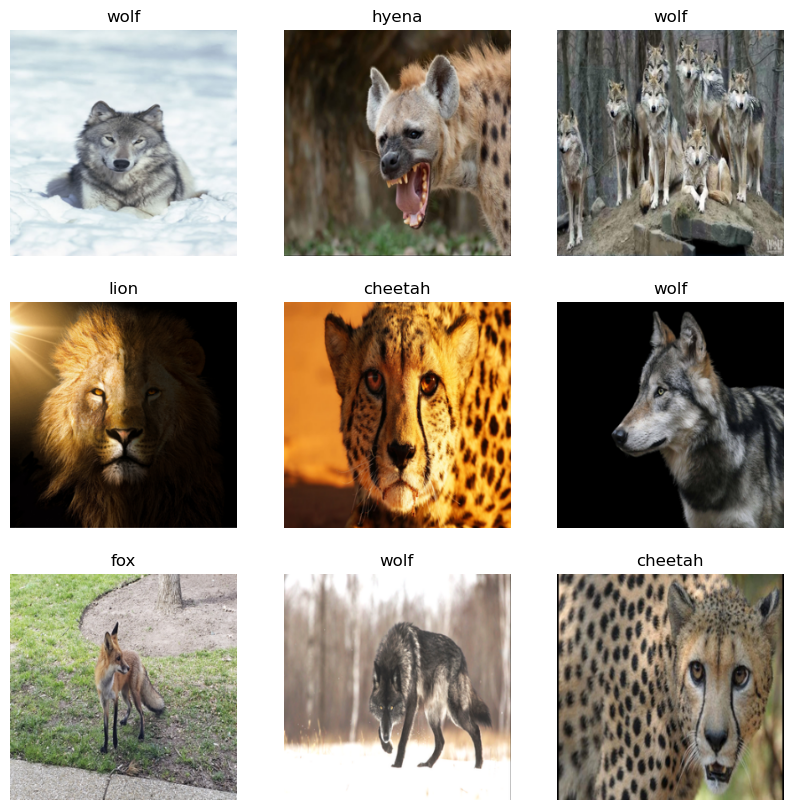

In [6]:
imgs, labels = next(iter(train_data))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(imgs[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [7]:
class ConvBlock(tf.keras.models.Model):
    def __init__(self, num_filters, kernel_size,pool = False,dropout= False):
        super(ConvBlock, self).__init__()
        self.conv = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=kernel_size, padding='same')
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.pool = tf.keras.layers.MaxPool2D() if pool else None
        self.dropout = tf.keras.layers.Dropout(0.3) if dropout else None

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.relu(x)
        if self.pool is not None:
            x = self.pool(x)
        if self.dropout is not None:
            x = self.dropout(x)
        return x

In [8]:
sample_block = ConvBlock(64, 3)
tmp = sample_block(imgs)
tmp.shape

TensorShape([16, 256, 256, 64])

In [9]:
class AnimalClassifier(tf.keras.Model):
    def __init__(self, num_classes):
        super(AnimalClassifier, self).__init__()
        self.block1 = ConvBlock(64, 3)
        self.block2 = ConvBlock(128, 3, pool=True,dropout=True)
        self.block3 = ConvBlock(256, 3, pool=True,dropout=True)
        self.block4 = ConvBlock(512, 3, pool=True,dropout=True)
        self.pool = tf.keras.layers.GlobalAveragePooling2D()
        self.d1 = tf.keras.layers.Dense(512, activation='relu')
        self.drop1 = tf.keras.layers.Dropout(0.3)
        self.d2 = tf.keras.layers.Dense(256, activation='relu')
        self.drop2 = tf.keras.layers.Dropout(0.3)
        self.d3 = tf.keras.layers.Dense(128, activation='relu')
        self.classifier = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.block1(inputs)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.pool(x)
        x = self.d1(x)
        x = self.drop1(x)
        x = self.d2(x)
        x = self.drop2(x)
        x = self.d3(x)
        return self.classifier(x)

In [10]:
writer = tf.summary.create_file_writer('logs')

In [11]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs', histogram_freq=1)

In [12]:
imgs.shape

TensorShape([16, 256, 256, 3])

In [13]:
lossfn = tf.keras.losses.SparseCategoricalCrossentropy()
model = AnimalClassifier(num_classes=len(class_names))
model.compile(optimizer='adam', loss=lossfn, metrics=['accuracy'])
model.build(imgs.shape)

In [ ]:
model.fit(train_data,epochs=10,callbacks= [tensorboard_callback])

Epoch 1/10


21/87 [======>.......................] - ETA: 5:54 - loss: 1.9394 - accuracy: 0.2411